# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
torch.set_float32_matmul_precision('high')
from train import *

device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

In [3]:

def simulate_BM(n_sample, dt, n_timestep):
    noise = torch.randn(size=(n_sample, n_timestep))
    paths_incr = noise * torch.sqrt(torch.tensor(dt))
    paths = torch.cumsum(paths_incr, axis=1)
    BM_paths = torch.cat([torch.zeros((n_sample, 1)), paths], axis=1)
    BM_paths = BM_paths[..., None]
    return BM_paths


def simulate_BS(n_sample, dt, n_timestep, mu, sigma):
    time_grid = torch.linspace(0, dt * n_timestep, n_timestep + 1)
    time_paths = time_grid.expand([n_sample, n_timestep + 1])[..., None]
    BM_paths = simulate_BM(n_sample, dt, n_timestep)
    BS_paths = torch.exp(sigma * BM_paths + (mu - 0.5 * sigma**2) * time_paths - 5)
    return BS_paths


start_date = '1990-01-01'
end_date = '2023-01-01'

t = pd.date_range(start=start_date, end=end_date)
n_timestep = len(t)
df = pd.DataFrame({'Date': t, 'spx': t})
df.set_index('Date', inplace=True)
dt = 1/365
mu = 0.1
sigma = 0.2
BS_paths = simulate_BS(1, dt, n_timestep-1, mu, sigma)
path = BS_paths[0,:,0].numpy().astype(np.float64)
df['spx'] = path
df.to_csv('data/bs.csv')

df = pd.read_csv('data/bs.csv', index_col=0, parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12054 entries, 1990-01-01 to 2023-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spx     12054 non-null  float64
dtypes: float64(1)
memory usage: 188.3 KB


<Axes: xlabel='Date'>

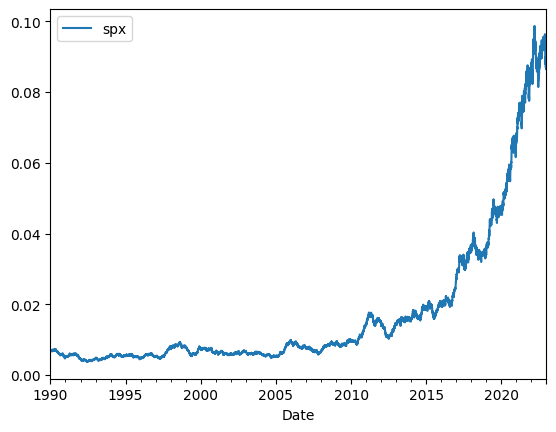

In [4]:
df.plot()

In [5]:
# samples
# BS
batch_size = 64 # number of samples in each batch
sample_len = 61 # length of each sample
stride = 60

sample_model = 'Realdt' # GBM, Heston, OU, RealData, Realdt, spx_rates
lead_lag = False # whether to use lead lag transformation
lags = [1] # number of lags to use for lead lag transformation: int or list[int]
seed = 42

In [6]:
# signature kernel
static_kernel_type = 'rq' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels = 5 # number of levels in the truncated signature kernel

# generator
seq_dim = 1 # dimension of sequence vector
activation = 'Tanh' # pytorch names e.g. Tanh, ReLU. NOTE: does NOT change transformer layers'
hidden_size = 64
n_lstm_layers = 1 # number of LSTM layers
conditional = True # feed in history for LSTM generators
hist_len = 2

In [7]:
noise_dim = 1 # dimension of noise vector
ma = True # whether to use MA noise generator fitted to log returns gaussianized by Lambert W transformation
ma_p = 5

### Training Related

In [8]:
epochs = 300 # number of batches
start_lr = 0.001 # starting learning rate
patience = 100 # number of epochs to wait before reducing lr
lr_factor = 0.5 # factor to multiply lr by for scheduler
early_stopping = patience*3 # number of epochs to wait before no improvement
kernel_sigma = 0.2 # starting kernel_sigma
num_losses = 20

### Save to tensorboard log

In [9]:
# save all parameters to a dictionary
rng = np.random.default_rng(seed)
torch.manual_seed(seed)

data_params, model_params, train_params = get_params_dicts(vars().copy())

# save parameters to tensorboard
writer = start_writer(data_params, model_params, train_params)

### Data, kernel, generator

In [10]:
dataloader = get_dataloader(**{**data_params, **model_params, 'bs':True})
kernel = get_signature_kernel(**{**model_params, **train_params})
generator = get_generator(**{**model_params, **data_params})
generator.to(device)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 17100.924048989553
            Iterations: 7
            Function evaluations: 56
            Gradient evaluations: 7
                        Zero Mean - ARCH Model Results                        
Dep. Variable:           gaussianized   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -17100.9
Distribution:                  Normal   AIC:                           34213.8
Method:            Maximum Likelihood   BIC:                           34258.2
                                        No. Observations:                12053
Date:                Wed, Sep 04 2024   Df Residuals:                    12053
Time:                        16:35:30   Df Model:                            0
                               Volatility Model                              
   

GenLSTM(
  (rnn): LSTM(3, 64, batch_first=True)
  (mean_net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (var_net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (output_net): Linear(in_features=64, out_features=1, bias=True)
)

2
torch.Size([64, 61, 2])
torch.Size([64, 60, 1])


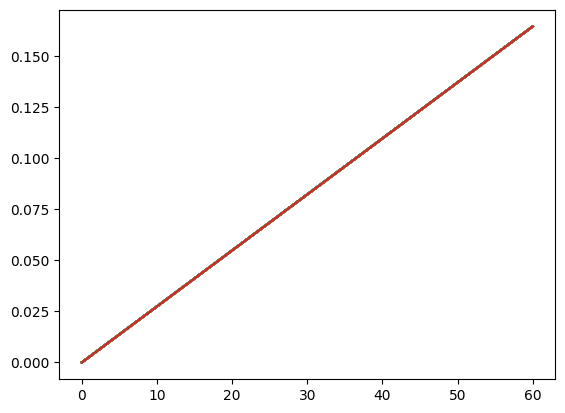

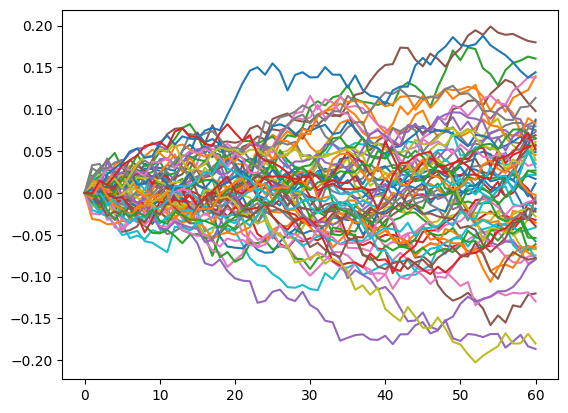

In [11]:
# Visualize data
for item in dataloader:
    print(len(item))
    print(item[0].shape)
    print(item[1].shape)
    break
plt.plot(item[0][:,:,0].T)
plt.show()
plt.plot(item[0][:,:,1].T)
plt.show()

# Train MMD-GAN

In [12]:
train(generator, kernel, dataloader, rng, writer, device, **{**train_params, **model_params, **data_params})

/u/hous/Generative-Model-Signature-MMD/.venv/lib64/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Epoch 0, loss: 766.4552205403646, avg_last_20_loss: 766.4552205403646
Saving model at epoch 0


100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Epoch 1, loss: 232.78693644205728, avg_last_20_loss: 499.62107849121094
Saving model at epoch 1


100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


Epoch 2, loss: 28.01873540878296, avg_last_20_loss: 342.4202974637349
Saving model at epoch 2


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 3, loss: 4.352187712987264, avg_last_20_loss: 257.903270026048
Saving model at epoch 3


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 4, loss: 36.37576548258463, avg_last_20_loss: 213.59776911735534
Saving model at epoch 4


100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


Epoch 5, loss: 51.87443923950195, avg_last_20_loss: 186.6438808043798
Saving model at epoch 5


100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


Epoch 6, loss: 31.31411616007487, avg_last_20_loss: 164.45391442662194
Saving model at epoch 6


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 7, loss: 11.485295295715332, avg_last_20_loss: 145.3328370352586
Saving model at epoch 7


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 8, loss: 2.838205655415853, avg_last_20_loss: 129.50010021527606
Saving model at epoch 8


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 9, loss: 0.6959972381591797, avg_last_20_loss: 116.61968991756437
Saving model at epoch 9


100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


Epoch 10, loss: 1.1785365740458171, avg_last_20_loss: 106.12503961360814
Saving model at epoch 10


100%|██████████| 3/3 [00:00<00:00,  3.85it/s]


Epoch 11, loss: 2.2923618952433267, avg_last_20_loss: 97.47231647041109
Saving model at epoch 11


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 12, loss: 3.2633144855499268, avg_last_20_loss: 90.2254701638833
Saving model at epoch 12


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 13, loss: 3.155884345372518, avg_last_20_loss: 84.00621403398966
Saving model at epoch 13


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 14, loss: 3.36793581644694, avg_last_20_loss: 78.63032881948682
Saving model at epoch 14


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 15, loss: 2.191295862197876, avg_last_20_loss: 73.85288925965627
Saving model at epoch 15


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 16, loss: 1.7657406330108643, avg_last_20_loss: 69.61246875220654
Saving model at epoch 16


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 17, loss: 1.093334436416626, avg_last_20_loss: 65.8058501791071
Saving model at epoch 17


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 18, loss: 0.824669599533081, avg_last_20_loss: 62.38578804334004
Saving model at epoch 18


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 19, loss: 0.8585841655731201, avg_last_20_loss: 59.309427849451694
Saving model at epoch 19


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 20, loss: 0.6709391276041666, avg_last_20_loss: 21.02021377881368
Saving model at epoch 20


100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


Epoch 21, loss: 0.8463931878407797, avg_last_20_loss: 9.423186616102857
Saving model at epoch 21


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 22, loss: 0.7128028074900309, avg_last_20_loss: 8.057889986038209
Saving model at epoch 22


100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


Epoch 23, loss: 0.8675339221954346, avg_last_20_loss: 7.883657296498616
Saving model at epoch 23


100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


Epoch 24, loss: 0.9225643475850424, avg_last_20_loss: 6.110997239748636
Saving model at epoch 24


100%|██████████| 3/3 [00:00<00:00,  3.86it/s]


Epoch 25, loss: 0.8197799523671468, avg_last_20_loss: 3.5582642753918967
Saving model at epoch 25


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 26, loss: 0.8017427921295166, avg_last_20_loss: 2.0326456069946293
Saving model at epoch 26


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 27, loss: 0.6512919267018636, avg_last_20_loss: 1.4909454385439553
Saving model at epoch 27


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 28, loss: 0.5931098461151123, avg_last_20_loss: 1.3786906480789185
Saving model at epoch 28


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 29, loss: 0.7807629903157552, avg_last_20_loss: 1.3829289356867471


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 30, loss: 0.7911102771759033, avg_last_20_loss: 1.3635576208432514
Saving model at epoch 30


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 31, loss: 0.7214969793955485, avg_last_20_loss: 1.2850143750508627
Saving model at epoch 31


100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


Epoch 32, loss: 0.7642383575439453, avg_last_20_loss: 1.1600605686505636
Saving model at epoch 32


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 33, loss: 0.6641055742899576, avg_last_20_loss: 1.0354716300964355
Saving model at epoch 33


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 34, loss: 0.6598869959513346, avg_last_20_loss: 0.9000691890716552
Saving model at epoch 34


100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


Epoch 35, loss: 0.8231998284657797, avg_last_20_loss: 0.8316643873850504
Saving model at epoch 35


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 36, loss: 0.9067103862762451, avg_last_20_loss: 0.7887128750483196
Saving model at epoch 36


100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


Epoch 37, loss: 0.6069246927897135, avg_last_20_loss: 0.7643923878669738
Saving model at epoch 37


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch 38, loss: 0.704409122467041, avg_last_20_loss: 0.7583793640136719
Saving model at epoch 38


100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch 39, loss: 0.623679002126058, avg_last_20_loss: 0.7466341058413187
Saving model at epoch 39


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 40, loss: 0.634382406870524, avg_last_20_loss: 0.7448062698046367
Saving model at epoch 40


100%|██████████| 3/3 [00:00<00:00,  3.86it/s]


Epoch 41, loss: 0.549036979675293, avg_last_20_loss: 0.7299384593963623
Saving model at epoch 41


100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Epoch 42, loss: 0.6752447287241617, avg_last_20_loss: 0.7280605554580688
Saving model at epoch 42


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch 43, loss: 0.621668815612793, avg_last_20_loss: 0.7157673001289366
Saving model at epoch 43


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch 44, loss: 0.5648435751597086, avg_last_20_loss: 0.69788126150767
Saving model at epoch 44


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Epoch 45, loss: 0.5785083770751953, avg_last_20_loss: 0.6858176827430724
Saving model at epoch 45


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch 46, loss: 0.6377435525258383, avg_last_20_loss: 0.6776177207628885
Saving model at epoch 46


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


Epoch 47, loss: 0.5757431983947754, avg_last_20_loss: 0.6738402843475342
Saving model at epoch 47


100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


Epoch 48, loss: 0.48734362920125324, avg_last_20_loss: 0.6685519735018413
Saving model at epoch 48


100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


Epoch 49, loss: 0.6093949476877848, avg_last_20_loss: 0.6599835713704427
Saving model at epoch 49


100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


Epoch 50, loss: 0.518778403600057, avg_last_20_loss: 0.6463669776916504
Saving model at epoch 50


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch 51, loss: 0.5185155868530273, avg_last_20_loss: 0.6362179080645244
Saving model at epoch 51


100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


Epoch 52, loss: 0.7110682328542074, avg_last_20_loss: 0.6335594018300374
Saving model at epoch 52


100%|██████████| 3/3 [00:00<00:00,  3.85it/s]


Epoch 53, loss: 0.6175664265950521, avg_last_20_loss: 0.6312324444452923
Saving model at epoch 53


100%|██████████| 3/3 [00:00<00:00,  3.86it/s]


Epoch 54, loss: 0.475560983022054, avg_last_20_loss: 0.6220161437988282
Saving model at epoch 54


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 55, loss: 0.5491237640380859, avg_last_20_loss: 0.6083123405774435
Saving model at epoch 55


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 56, loss: 0.48826972643534344, avg_last_20_loss: 0.5873903075853983
Saving model at epoch 56


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 57, loss: 0.588886022567749, avg_last_20_loss: 0.5864883740743002
Saving model at epoch 57


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 58, loss: 0.532153050104777, avg_last_20_loss: 0.5778755704561869
Saving model at epoch 58


100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Epoch 59, loss: 0.5401018460591634, avg_last_20_loss: 0.5736967126528422
Saving model at epoch 59


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 60, loss: 0.5117557843526205, avg_last_20_loss: 0.567565381526947
Saving model at epoch 60


100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


Epoch 61, loss: 0.49666428565979004, avg_last_20_loss: 0.564946746826172
Saving model at epoch 61


100%|██████████| 3/3 [00:00<00:00,  3.86it/s]


Epoch 62, loss: 0.5318573315938314, avg_last_20_loss: 0.5577773769696555
Saving model at epoch 62


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 63, loss: 0.5394190152486166, avg_last_20_loss: 0.5536648869514467
Saving model at epoch 63


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 64, loss: 0.6306205590566, avg_last_20_loss: 0.5569537361462912


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 65, loss: 0.5563720067342123, avg_last_20_loss: 0.5558469176292421


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 66, loss: 0.4735110600789388, avg_last_20_loss: 0.5476352930068971
Saving model at epoch 66


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 67, loss: 0.5378561019897461, avg_last_20_loss: 0.5457409381866456
Saving model at epoch 67


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 68, loss: 0.4784071445465088, avg_last_20_loss: 0.5452941139539084
Saving model at epoch 68


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 69, loss: 0.43933947881062824, avg_last_20_loss: 0.5367913405100506
Saving model at epoch 69


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 70, loss: 0.4754950205485026, avg_last_20_loss: 0.5346271713574728
Saving model at epoch 70


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Epoch 71, loss: 0.4592924118041992, avg_last_20_loss: 0.5316660126050314
Saving model at epoch 71


100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


Epoch 72, loss: 0.45441222190856934, avg_last_20_loss: 0.5188332120577495
Saving model at epoch 72


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 73, loss: 0.5078761577606201, avg_last_20_loss: 0.5133486986160278
Saving model at epoch 73


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 74, loss: 0.5002467632293701, avg_last_20_loss: 0.5145829876263937


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 75, loss: 0.49192166328430176, avg_last_20_loss: 0.5117228825887045
Saving model at epoch 75


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 76, loss: 0.5128992398579916, avg_last_20_loss: 0.5129543582598368


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 77, loss: 0.38120094935099286, avg_last_20_loss: 0.502570104598999
Saving model at epoch 77


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 78, loss: 0.43331027030944824, avg_last_20_loss: 0.4976279656092326
Saving model at epoch 78


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 79, loss: 0.3925483226776123, avg_last_20_loss: 0.49025028944015503
Saving model at epoch 79


100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


Epoch 80, loss: 0.5021592775980631, avg_last_20_loss: 0.4897704641024271
Saving model at epoch 80


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 81, loss: 0.4143966833750407, avg_last_20_loss: 0.48565708398818963
Saving model at epoch 81


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 82, loss: 0.41113654772440594, avg_last_20_loss: 0.47962104479471834
Saving model at epoch 82


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 83, loss: 0.47179659207661945, avg_last_20_loss: 0.4762399236361185
Saving model at epoch 83


100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


Epoch 84, loss: 0.4294976393381755, avg_last_20_loss: 0.4661837776501973
Saving model at epoch 84


100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


Epoch 85, loss: 0.3868836561838786, avg_last_20_loss: 0.4577093601226806
Saving model at epoch 85


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 86, loss: 0.48696080843607586, avg_last_20_loss: 0.45838184754053746


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Epoch 87, loss: 0.3524458408355713, avg_last_20_loss: 0.4491113344828288
Saving model at epoch 87


100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Epoch 88, loss: 0.3651747703552246, avg_last_20_loss: 0.4434497157732646
Saving model at epoch 88


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Epoch 89, loss: 0.421855370203654, avg_last_20_loss: 0.4425755103429158
Saving model at epoch 89


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 90, loss: 0.38087646166483563, avg_last_20_loss: 0.4378445823987325
Saving model at epoch 90


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Epoch 91, loss: 0.3751222292582194, avg_last_20_loss: 0.43363607327143355
Saving model at epoch 91


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Epoch 92, loss: 0.3805551528930664, avg_last_20_loss: 0.4299432198206584
Saving model at epoch 92


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 93, loss: 0.4564982255299886, avg_last_20_loss: 0.4273743232091268
Saving model at epoch 93


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 94, loss: 0.4133756160736084, avg_last_20_loss: 0.4230307658513387
Saving model at epoch 94


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 95, loss: 0.387600580851237, avg_last_20_loss: 0.4178147117296855
Saving model at epoch 95


100%|██████████| 3/3 [00:00<00:00,  3.86it/s]


Epoch 96, loss: 0.3974463144938151, avg_last_20_loss: 0.4120420654614766
Saving model at epoch 96


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Epoch 97, loss: 0.32399900754292804, avg_last_20_loss: 0.40918196837107346
Saving model at epoch 97


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 98, loss: 0.28972458839416504, avg_last_20_loss: 0.40200268427530916
Saving model at epoch 98


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 99, loss: 0.389229695002238, avg_last_20_loss: 0.4018367528915405
Saving model at epoch 99


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Epoch 100, loss: 0.3544003963470459, avg_last_20_loss: 0.3944488088289897
Saving model at epoch 100


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Epoch 101, loss: 0.3372778097788493, avg_last_20_loss: 0.3905928651491801
Saving model at epoch 101


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Epoch 102, loss: 0.3569173812866211, avg_last_20_loss: 0.3878819068272909
Saving model at epoch 102


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 103, loss: 0.367412010828654, avg_last_20_loss: 0.3826626777648926
Saving model at epoch 103


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 104, loss: 0.349265178044637, avg_last_20_loss: 0.37865105470021565
Saving model at epoch 104


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Epoch 105, loss: 0.3228418827056885, avg_last_20_loss: 0.3754489660263062
Saving model at epoch 105


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 106, loss: 0.37093639373779297, avg_last_20_loss: 0.36964774529139205
Saving model at epoch 106


100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


Epoch 107, loss: 0.3812848726908366, avg_last_20_loss: 0.3710896968841553


100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


Epoch 108, loss: 0.3323107560475667, avg_last_20_loss: 0.3694464961687724
Saving model at epoch 108


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 109, loss: 0.31061514218648273, avg_last_20_loss: 0.3638844847679138
Saving model at epoch 109


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 110, loss: 0.35226980845133465, avg_last_20_loss: 0.36245415210723875
Saving model at epoch 110


100%|██████████| 3/3 [00:00<00:00,  3.85it/s]


Epoch 111, loss: 0.2926499843597412, avg_last_20_loss: 0.35833053986231483
Saving model at epoch 111


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 112, loss: 0.3367740313212077, avg_last_20_loss: 0.35614148378372196
Saving model at epoch 112


100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


Epoch 113, loss: 0.29172539710998535, avg_last_20_loss: 0.34790284236272184
Saving model at epoch 113


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 114, loss: 0.31238651275634766, avg_last_20_loss: 0.34285338719685876
Saving model at epoch 114


100%|██████████| 3/3 [00:00<00:00,  3.85it/s]


Epoch 115, loss: 0.32526063919067383, avg_last_20_loss: 0.3397363901138306
Saving model at epoch 115


100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Epoch 116, loss: 0.24989779790242514, avg_last_20_loss: 0.3323589642842611
Saving model at epoch 116


100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch 117, loss: 0.3337753613789876, avg_last_20_loss: 0.332847781976064


100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


Epoch 118, loss: 0.2930847803751628, avg_last_20_loss: 0.3330157915751139


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Epoch 119, loss: 0.25140810012817383, avg_last_20_loss: 0.32612471183141073
Saving model at epoch 119


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 120, loss: 0.24999753634134927, avg_last_20_loss: 0.32090456883112595
Saving model at epoch 120


100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


Epoch 121, loss: 0.2906561692555745, avg_last_20_loss: 0.3185734868049622
Saving model at epoch 121


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 122, loss: 0.268635352452596, avg_last_20_loss: 0.3141593853632609
Saving model at epoch 122


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 123, loss: 0.2621244589487712, avg_last_20_loss: 0.3088950077692668
Saving model at epoch 123


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 124, loss: 0.2356100877126058, avg_last_20_loss: 0.3032122532526652
Saving model at epoch 124


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Epoch 125, loss: 0.2558267116546631, avg_last_20_loss: 0.2998614947001139
Saving model at epoch 125


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 126, loss: 0.27487850189208984, avg_last_20_loss: 0.2950586001078288
Saving model at epoch 126


100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


Epoch 127, loss: 0.23746832211812338, avg_last_20_loss: 0.2878677725791931
Saving model at epoch 127


100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


Epoch 128, loss: 0.22450796763102213, avg_last_20_loss: 0.28247763315836594
Saving model at epoch 128


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 129, loss: 0.24688132603963217, avg_last_20_loss: 0.27929094235102336
Saving model at epoch 129


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 130, loss: 0.2573548952738444, avg_last_20_loss: 0.2745451966921489
Saving model at epoch 130


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 131, loss: 0.23172100385030112, avg_last_20_loss: 0.2714987476666768
Saving model at epoch 131


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 132, loss: 0.2783774534861247, avg_last_20_loss: 0.2685789187749227
Saving model at epoch 132


100%|██████████| 3/3 [00:00<00:00,  3.85it/s]


Epoch 133, loss: 0.23240073521931967, avg_last_20_loss: 0.2656126856803894
Saving model at epoch 133


100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


Epoch 134, loss: 0.22771946589152017, avg_last_20_loss: 0.261379333337148
Saving model at epoch 134


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 135, loss: 0.23025147120157877, avg_last_20_loss: 0.2566288749376933
Saving model at epoch 135


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 136, loss: 0.26104172070821124, avg_last_20_loss: 0.25718607107798264


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 137, loss: 0.21284071604410806, avg_last_20_loss: 0.2511393388112387
Saving model at epoch 137


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Epoch 138, loss: 0.21636025110880533, avg_last_20_loss: 0.24730311234792074
Saving model at epoch 138


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 139, loss: 0.24847912788391113, avg_last_20_loss: 0.2471566637357076
Saving model at epoch 139


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Epoch 140, loss: 0.2212642033894857, avg_last_20_loss: 0.2457199970881144
Saving model at epoch 140


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Epoch 141, loss: 0.1942478815714518, avg_last_20_loss: 0.2408995827039083
Saving model at epoch 141


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 142, loss: 0.2177398999532064, avg_last_20_loss: 0.23835481007893883
Saving model at epoch 142


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 143, loss: 0.22506491343180338, avg_last_20_loss: 0.23650183280309042
Saving model at epoch 143


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Epoch 144, loss: 0.1890392303466797, avg_last_20_loss: 0.23417328993479414
Saving model at epoch 144


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 145, loss: 0.15120697021484375, avg_last_20_loss: 0.22894230286280312
Saving model at epoch 145


100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


Epoch 146, loss: 0.19288269678751627, avg_last_20_loss: 0.2248425126075745
Saving model at epoch 146


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch 147, loss: 0.17819579442342123, avg_last_20_loss: 0.22187888622283936
Saving model at epoch 147


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch 148, loss: 0.14204605420430502, avg_last_20_loss: 0.21775579055150346
Saving model at epoch 148


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 149, loss: 0.16791613896687826, avg_last_20_loss: 0.21380753119786577
Saving model at epoch 149


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 150, loss: 0.17715771993001303, avg_last_20_loss: 0.2097976724306742
Saving model at epoch 150


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 151, loss: 0.15451415379842123, avg_last_20_loss: 0.20593732992808028
Saving model at epoch 151


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 152, loss: 0.16265392303466797, avg_last_20_loss: 0.20015115340550743
Saving model at epoch 152


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 153, loss: 0.16956472396850586, avg_last_20_loss: 0.19700935284296675
Saving model at epoch 153


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 154, loss: 0.1350108782450358, avg_last_20_loss: 0.19237392346064247
Saving model at epoch 154


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 155, loss: 0.14882095654805502, avg_last_20_loss: 0.1883023977279663
Saving model at epoch 155


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 156, loss: 0.15643072128295898, avg_last_20_loss: 0.1830718477567037
Saving model at epoch 156


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 157, loss: 0.14268318812052408, avg_last_20_loss: 0.1795639713605245
Saving model at epoch 157


100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


Epoch 158, loss: 0.1515058676401774, avg_last_20_loss: 0.1763212521870931
Saving model at epoch 158


100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


Epoch 159, loss: 0.1486684481302897, avg_last_20_loss: 0.171330718199412
Saving model at epoch 159


100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


Epoch 160, loss: 0.14124790827433267, avg_last_20_loss: 0.16732990344365434
Saving model at epoch 160


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Epoch 161, loss: 0.15045579274495444, avg_last_20_loss: 0.1651402990023295
Saving model at epoch 161


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 162, loss: 0.12409448623657227, avg_last_20_loss: 0.16045802831649777
Saving model at epoch 162


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 163, loss: 0.13434561093648276, avg_last_20_loss: 0.1559220631917318
Saving model at epoch 163


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 164, loss: 0.12503568331400552, avg_last_20_loss: 0.15272188584009808
Saving model at epoch 164


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 165, loss: 0.13383054733276367, avg_last_20_loss: 0.15185306469599408
Saving model at epoch 165


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 166, loss: 0.15588847796122232, avg_last_20_loss: 0.15000335375467935
Saving model at epoch 166


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 167, loss: 0.14937734603881836, avg_last_20_loss: 0.14856243133544922
Saving model at epoch 167


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 168, loss: 0.11792826652526855, avg_last_20_loss: 0.1473565419514974
Saving model at epoch 168


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


Epoch 169, loss: 0.12674935658772787, avg_last_20_loss: 0.14529820283253986
Saving model at epoch 169


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch 170, loss: 0.12018481890360515, avg_last_20_loss: 0.14244955778121948
Saving model at epoch 170


100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


Epoch 171, loss: 0.10983482996622722, avg_last_20_loss: 0.14021559158960978
Saving model at epoch 171


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 172, loss: 0.10908651351928711, avg_last_20_loss: 0.13753722111384073
Saving model at epoch 172


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 173, loss: 0.0988164742787679, avg_last_20_loss: 0.13399980862935384
Saving model at epoch 173


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 174, loss: 0.11244535446166992, avg_last_20_loss: 0.13287153244018554
Saving model at epoch 174


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


Epoch 175, loss: 0.1103363831837972, avg_last_20_loss: 0.13094730377197267
Saving model at epoch 175


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 176, loss: 0.10989697774251302, avg_last_20_loss: 0.12862061659495036
Saving model at epoch 176


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 177, loss: 0.1029202938079834, avg_last_20_loss: 0.12663247187932333
Saving model at epoch 177


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 178, loss: 0.10976576805114746, avg_last_20_loss: 0.12454546689987182
Saving model at epoch 178


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 179, loss: 0.11881470680236816, avg_last_20_loss: 0.12305277983347576
Saving model at epoch 179


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 180, loss: 0.09926025072733562, avg_last_20_loss: 0.12095339695612588
Saving model at epoch 180


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 181, loss: 0.09769105911254883, avg_last_20_loss: 0.11831516027450562
Saving model at epoch 181


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch 182, loss: 0.09429168701171875, avg_last_20_loss: 0.11682502031326292
Saving model at epoch 182


100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


Epoch 183, loss: 0.09627922375996907, avg_last_20_loss: 0.11492170095443725
Saving model at epoch 183


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 184, loss: 0.0905461311340332, avg_last_20_loss: 0.11319722334543865
Saving model at epoch 184


100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


Epoch 185, loss: 0.08713618914286296, avg_last_20_loss: 0.1108625054359436
Saving model at epoch 185


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 186, loss: 0.10007969538370769, avg_last_20_loss: 0.10807206630706787
Saving model at epoch 186


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 187, loss: 0.0974581241607666, avg_last_20_loss: 0.10547610521316528
Saving model at epoch 187


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 188, loss: 0.09577488899230957, avg_last_20_loss: 0.10436843633651734
Saving model at epoch 188


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 189, loss: 0.0917063554128011, avg_last_20_loss: 0.102616286277771
Saving model at epoch 189


100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


Epoch 190, loss: 0.10228323936462402, avg_last_20_loss: 0.10172120730082193
Saving model at epoch 190


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 191, loss: 0.08205612500508626, avg_last_20_loss: 0.10033227205276489
Saving model at epoch 191


100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


Epoch 192, loss: 0.08351691563924153, avg_last_20_loss: 0.0990537921587626
Saving model at epoch 192


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Epoch 193, loss: 0.08496642112731934, avg_last_20_loss: 0.09836128950119019
Saving model at epoch 193


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 194, loss: 0.08990224202473958, avg_last_20_loss: 0.09723413387934367
Saving model at epoch 194


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 195, loss: 0.0850075085957845, avg_last_20_loss: 0.09596769014994302
Saving model at epoch 195


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 196, loss: 0.08460911115010579, avg_last_20_loss: 0.09470329682032266
Saving model at epoch 196


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 197, loss: 0.08495720227559407, avg_last_20_loss: 0.0938051422437032
Saving model at epoch 197


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch 198, loss: 0.08797987302144368, avg_last_20_loss: 0.092715847492218
Saving model at epoch 198


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 199, loss: 0.09253795941670735, avg_last_20_loss: 0.09140201012293496
Saving model at epoch 199


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 200, loss: 0.08913660049438477, avg_last_20_loss: 0.09089582761128742
Saving model at epoch 200


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 201, loss: 0.08410708109537761, avg_last_20_loss: 0.09021662871042888
Saving model at epoch 201


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 202, loss: 0.08906038602193196, avg_last_20_loss: 0.08995506366093954
Saving model at epoch 202


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 203, loss: 0.08560450871785481, avg_last_20_loss: 0.08942132790883381
Saving model at epoch 203


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch 204, loss: 0.08353225390116374, avg_last_20_loss: 0.08907063404719034
Saving model at epoch 204


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch 205, loss: 0.07968902587890625, avg_last_20_loss: 0.08869827588399251
Saving model at epoch 205


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch 206, loss: 0.08240278561909993, avg_last_20_loss: 0.08781443039576212
Saving model at epoch 206


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 207, loss: 0.08007049560546875, avg_last_20_loss: 0.08694504896799723
Saving model at epoch 207


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 208, loss: 0.08701809247334798, avg_last_20_loss: 0.08650720914204915
Saving model at epoch 208


100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


Epoch 209, loss: 0.08020710945129395, avg_last_20_loss: 0.08593224684397378
Saving model at epoch 209


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 210, loss: 0.0888511339823405, avg_last_20_loss: 0.08526064157485962
Saving model at epoch 210


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 211, loss: 0.08623631795247395, avg_last_20_loss: 0.08546965122222899


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 212, loss: 0.0783995787302653, avg_last_20_loss: 0.08521378437678019
Saving model at epoch 212


100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


Epoch 213, loss: 0.08107217152913411, avg_last_20_loss: 0.08501907189687093
Saving model at epoch 213


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 214, loss: 0.08000564575195312, avg_last_20_loss: 0.0845242420832316
Saving model at epoch 214


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 215, loss: 0.08269691467285156, avg_last_20_loss: 0.08440871238708496
Saving model at epoch 215


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 216, loss: 0.08693472544352214, avg_last_20_loss: 0.08452499310175579


100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


Epoch 217, loss: 0.07465108235677083, avg_last_20_loss: 0.0840096871058146
Saving model at epoch 217


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 218, loss: 0.07461889584859212, avg_last_20_loss: 0.08334163824717203
Saving model at epoch 218


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch 219, loss: 0.0802144209543864, avg_last_20_loss: 0.08272546132405598
Saving model at epoch 219


100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


Epoch 220, loss: 0.08615493774414062, avg_last_20_loss: 0.08257637818654379
Saving model at epoch 220


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 221, loss: 0.08011420567830403, avg_last_20_loss: 0.0823767344156901
Saving model at epoch 221


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 222, loss: 0.08135517438252766, avg_last_20_loss: 0.08199147383371988
Saving model at epoch 222


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 223, loss: 0.09458041191101074, avg_last_20_loss: 0.08244026899337767


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 224, loss: 0.07595014572143555, avg_last_20_loss: 0.08206116358439126


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 225, loss: 0.08025471369425456, avg_last_20_loss: 0.08208944797515869


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 226, loss: 0.08194533983866374, avg_last_20_loss: 0.08206657568613689


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 227, loss: 0.09267385800679524, avg_last_20_loss: 0.0826967438062032


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 228, loss: 0.07345819473266602, avg_last_20_loss: 0.08201874891916912


100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


Epoch 229, loss: 0.07888754208882649, avg_last_20_loss: 0.08195277055104574
Saving model at epoch 229


100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


Epoch 230, loss: 0.07109761238098145, avg_last_20_loss: 0.08106509447097779
Saving model at epoch 230


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch 231, loss: 0.08642784754435222, avg_last_20_loss: 0.0810746709505717


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 232, loss: 0.07893991470336914, avg_last_20_loss: 0.0811016877492269


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 233, loss: 0.07987721761067708, avg_last_20_loss: 0.08104194005330403
Saving model at epoch 233


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 234, loss: 0.07814939816792806, avg_last_20_loss: 0.08094912767410278
Saving model at epoch 234


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Epoch 235, loss: 0.07893252372741699, avg_last_20_loss: 0.08076090812683105
Saving model at epoch 235


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 236, loss: 0.0729820728302002, avg_last_20_loss: 0.08006327549616496
Saving model at epoch 236


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 237, loss: 0.07666246096293132, avg_last_20_loss: 0.08016384442647298


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 238, loss: 0.07271766662597656, avg_last_20_loss: 0.08006878296534221


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 239, loss: 0.07437856992085774, avg_last_20_loss: 0.07977699041366577
Saving model at epoch 239


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 240, loss: 0.07809877395629883, avg_last_20_loss: 0.07937418222427368
Saving model at epoch 240


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Epoch 241, loss: 0.06929103533426921, avg_last_20_loss: 0.07883302370707193
Saving model at epoch 241


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch 242, loss: 0.09418249130249023, avg_last_20_loss: 0.07947438955307007


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 243, loss: 0.08430878321329753, avg_last_20_loss: 0.07896080811818441


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 244, loss: 0.07023501396179199, avg_last_20_loss: 0.07867505153020224
Saving model at epoch 244


100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch 245, loss: 0.07471664746602376, avg_last_20_loss: 0.07839814821879068
Saving model at epoch 245


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 246, loss: 0.07251389821370442, avg_last_20_loss: 0.07792657613754271
Saving model at epoch 246


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 247, loss: 0.07451128959655762, avg_last_20_loss: 0.07701844771703084
Saving model at epoch 247


100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


Epoch 248, loss: 0.08080259958902995, avg_last_20_loss: 0.07738566795984904


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 249, loss: 0.08153144518534343, avg_last_20_loss: 0.07751786311467489


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch 250, loss: 0.08335399627685547, avg_last_20_loss: 0.0781306823094686


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Epoch 251, loss: 0.07681584358215332, avg_last_20_loss: 0.07765008211135864


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 252, loss: 0.07567365964253743, avg_last_20_loss: 0.07748676935831705


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch 253, loss: 0.07010761896769206, avg_last_20_loss: 0.07699828942616779
Saving model at epoch 253


100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


Epoch 254, loss: 0.09013708432515462, avg_last_20_loss: 0.07759767373402914


100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


Epoch 255, loss: 0.07102370262145996, avg_last_20_loss: 0.07720223267873129


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch 256, loss: 0.08588679631551106, avg_last_20_loss: 0.07784746885299682


100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


Epoch 257, loss: 0.07839481035868327, avg_last_20_loss: 0.07793408632278441


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 258, loss: 0.08069753646850586, avg_last_20_loss: 0.07833307981491089


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 259, loss: 0.07766453425089519, avg_last_20_loss: 0.07849737803141277


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 260, loss: 0.06865286827087402, avg_last_20_loss: 0.07802508274714152


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 261, loss: 0.07389497756958008, avg_last_20_loss: 0.07825527985890707


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 262, loss: 0.07638200124104817, avg_last_20_loss: 0.07736525535583497


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 263, loss: 0.07106582323710124, avg_last_20_loss: 0.07670310735702515
Saving model at epoch 263


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch 264, loss: 0.07709201176961263, avg_last_20_loss: 0.07704595724741617


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 265, loss: 0.07633097966512044, avg_last_20_loss: 0.07712667385737101


100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch 266, loss: 0.07998442649841309, avg_last_20_loss: 0.07750020027160645


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 267, loss: 0.07915465037027995, avg_last_20_loss: 0.07773236831029257


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 268, loss: 0.07833194732666016, avg_last_20_loss: 0.07760883569717407


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 269, loss: 0.06845903396606445, avg_last_20_loss: 0.07695521513621013


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 270, loss: 0.08598518371582031, avg_last_20_loss: 0.07708677450815837


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 271, loss: 0.09073774019877116, avg_last_20_loss: 0.07778286933898927


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 272, loss: 0.07495482762654622, avg_last_20_loss: 0.0777469277381897


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 273, loss: 0.0933832327524821, avg_last_20_loss: 0.07891070842742921


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 274, loss: 0.07799998919169109, avg_last_20_loss: 0.07830385367075603


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 275, loss: 0.06746157010396321, avg_last_20_loss: 0.07812574704488118


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 276, loss: 0.0810862382253011, avg_last_20_loss: 0.07788571914037068


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 277, loss: 0.08653012911478679, avg_last_20_loss: 0.07829248507817585


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Epoch 278, loss: 0.07887919743855794, avg_last_20_loss: 0.07820156812667847


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 279, loss: 0.08132799466451009, avg_last_20_loss: 0.0783847411473592


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch 280, loss: 0.08466362953186035, avg_last_20_loss: 0.07918527921040852


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch 281, loss: 0.07259718577067058, avg_last_20_loss: 0.07912038962046306


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch 282, loss: 0.0774696667989095, avg_last_20_loss: 0.07917477289835612


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch 283, loss: 0.07147097587585449, avg_last_20_loss: 0.07919503053029378


100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


Epoch 284, loss: 0.07460745175679524, avg_last_20_loss: 0.0790708025296529


100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


Epoch 285, loss: 0.08491849899291992, avg_last_20_loss: 0.07950017849604288


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 286, loss: 0.07142678896586101, avg_last_20_loss: 0.07907229661941528


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 287, loss: 0.07742118835449219, avg_last_20_loss: 0.0789856235186259


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 288, loss: 0.07344905535380046, avg_last_20_loss: 0.07874147891998291


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 289, loss: 0.07165241241455078, avg_last_20_loss: 0.07890114784240723


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 290, loss: 0.07828712463378906, avg_last_20_loss: 0.07851624488830568


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Epoch 291, loss: 0.0731352965037028, avg_last_20_loss: 0.07763612270355226


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 292, loss: 0.08263039588928223, avg_last_20_loss: 0.07801990111668905


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 293, loss: 0.06832273801167806, avg_last_20_loss: 0.07676687637964885


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 294, loss: 0.07475582758585612, avg_last_20_loss: 0.07660466829935711
Saving model at epoch 294


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 295, loss: 0.0740516980489095, avg_last_20_loss: 0.07693417469660441


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 296, loss: 0.07854779561360677, avg_last_20_loss: 0.0768072525660197


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 297, loss: 0.0672464370727539, avg_last_20_loss: 0.07584306796391806
Saving model at epoch 297


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 298, loss: 0.07838002840677898, avg_last_20_loss: 0.07581810951232909
Saving model at epoch 298


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 299, loss: 0.07035001118977864, avg_last_20_loss: 0.07526921033859252
Saving model at epoch 299


In [13]:
# dict = torch.load('runs/Sep01_20-18-02_ada-29_rq_10/generator.pt', map_location=torch.device('cpu'))

100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


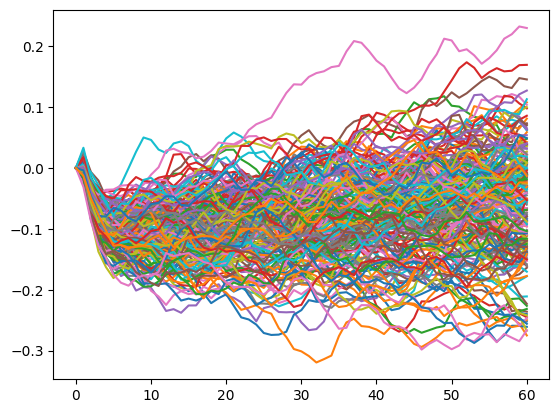

In [18]:
with torch.no_grad():
    for X in tqdm(dataloader):
        if ma: # ma noise is generated for each batch within dataset class
            X, noise = X
            if noise.device != device: noise = noise.to(device)
        else: # Gaussian noise is generated for each batch
            noise = torch.tensor(rng.normal(size=(batch_size, sample_len-1, noise_dim)), device=device, dtype=torch.float32, requires_grad=False)
        X = X.to(device)

        t = X[:,:,:1] # time dimension of path is always first series of the last dim
        if conditional:
            hist_x = X[:,:hist_len,1:] # history portion of path
            output = generator(noise, t, hist_x=hist_x)
            output = torch.cat([t, output], axis=-1) # concatenate time and history + generated path along time series value dimension
            # remove history portion from X and output to compute MMD only on generated path
            X = X[:,hist_len:,:]
            # output = output[:,hist_len:,:]
        else:
            output = generator(noise, t)
            output = torch.cat([t, output], axis=-1) # concatenate time and generated path along time series value dimension

        plt.plot(output[:,:,1].cpu().T)


In [15]:
output[:,hist_len:,1].diff().std() * np.sqrt(365), np.log(df['spx']).diff().std() * np.sqrt(365)

(tensor(0.2390, device='cuda:1'), 0.19867249151006913)

In [16]:
output[:,hist_len:,1].diff().mean() * 365, np.log(df['spx']).diff().mean() * 365

(tensor(0.1699, device='cuda:1'), 0.07814826193675911)

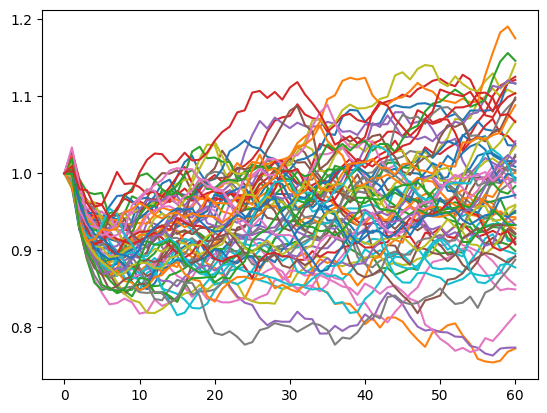

In [17]:
plt.plot(np.exp(output[:,:,1].cpu()).T);